In [2]:
#UDACITY UD730 - assignement 1 notMNIST
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


In [7]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


In [8]:
print (os.path.abspath(''))

C:\Users\Vince\Documents\GitHub\UD730


In [10]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for .\notMNIST_large. This may take a while. Please wait.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
Extracting data for .\notMNIST_small. This may take a while. Please wait.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [13]:
#Problem 1 : Let's take a peek at some of the data to make sure it looks sensible.
#Each exemplar should be an image of a character A through J rendered in a different font. 
#Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

listOfImageNames = ['notMNIST_large/I/R2VvbWV0cmljIFNsYWJzZXJpZiA3MDMgQm9sZCBJdGFsaWMucGZi.png',
                    'notMNIST_large/J/aG9uZXkgVWx0cmEudHRm.png',
                    'notMNIST_large/A/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/B/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/C/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/D/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/E/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/F/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/G/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/H/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/I/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/J/aG9tZXdvcmsgbm9ybWFsLnR0Zg==.png',
                    'notMNIST_large/C/a2ltaWRvcmkgbXVnY3VwLnR0Zg==.png']

listOfSmallImageNames = ['notMNIST_small/J/Q2FzdWFsLnR0Zg==.png',
                    'notMNIST_small/A/MTggSG9sZXMgQlJLLnR0Zg==.png',
                    'notMNIST_small/A/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/B/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/C/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/D/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/E/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/F/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/G/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/H/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/I/Q0sgUGluay50dGY=.png',
                    'notMNIST_small/J/Q0sgUGluay50dGY=.png']

#print (os.path.abspath(''))
print ("large images")
for imageName in listOfImageNames:
    display(Image(filename=imageName))
print ("small images")
for smallImageName in listOfSmallImageNames:
    display(Image(filename=smallImageName))

large images


small images


In [30]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  #print ('image_files ', image_files)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print ('dataset.size ', dataset.size, 'dataset.shape ', dataset.shape)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      #ndimage.imread = Read an image from a file as an array
      #Returns: img_array (ndarray). The different colour bands/channels are stored in the third dimension, 
      #such that a grey-image is MxN, an RGB-image MxNx3 and an RGBA-image MxNx4.
      #plus data normalization
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if (num_images % 25000) == 0:
          print ('num_images ', num_images, 'image_file ', image_file)
          display(Image(filename=image_file))
          print ('image_data ', image_data) 
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  #3D Matrix : normalized value of the W&B pixel per num_image x row (28) x col (28)
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
  print ('dataset [0:2,:,:] ',dataset [0:2,:,:])  
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
dataset.size  41483008 dataset.shape  (52912, 28, 28)
.\notMNIST_large\A
num_images  0 image_file  .\notMNIST_large\A\a29ydW5pc2hpLnR0Zg==.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.48431373 -0.5
  -0.19019608  0.46862745  0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.46862745 -0.19019608 -0.5        -0.48431373 -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.48823529 -0.5        -0.30392157
   0.43333333  0.5         0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.5         0.43333333 -0.30392157 -0.5        -0.48823529
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.48823529 -0.5        -0.37843137  0.38627451
   0.5         0.49215686  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.5         0.38627451 -0.37843137 -0.5        -0.48823529
  -0.5        -0.5       ]
 [-

Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '.\\notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
num_images  25000 image_file  .\notMNIST_large\A\SGVhZGxpbmUgRXh0ZW5kZWQgQm9sZC50dGY=.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.49215686 -0.5        -0.09215686
   0.41764706  0.41372549 -0.09215686 -0.5        -0.49215686 -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.48823529 -0.49607843 -0.30784314  0.48823529
   0.5         0.5         0.48431373 -0.33529412 -0.49607843 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.48823529 -0.5         0.12352941  0.5
   0.48431373  0.48039216  0.5         0.06862745 -0.5        -0.48823529
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-

Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '.\\notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
num_images  50000 image_file  .\notMNIST_large\A\VlRDS29taXhhdGlvbkNhcHMudHRm.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.5        -0.40980392 -0.09607843  0.1745098   0.34705882
   0.46862745  0.48039216 -0.09607843 -0.5        -0.48823529 -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.5        -0.04901961  0.41764706  0.5         0.49607843
   0.5         0.49215686  0.5         0.35098039 -0.46862745 -0.5
  -0.49607843 -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.49215686
  -0.5         0.03333333  0.5         0.49215686  0.49215686  0.48823529
   0.49215686  0.5         0.49215686  0.5        -0.23333333 -0.5
  -0.48823529 -0.5        -0.5       ]
 [-

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.48823529 ..., -0.48823529 -0.5        -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ...,  0.5         0.5         0.49215686]
  [-0.5        -0.5        -0.5        ...,  0.12352941  0.48039216  0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.24509804
    0.24509804]]

 [[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.48431373 ..., -0.48431373 -0.49607843 -0.5       ]
  [-0.49607843 -0.49607843 -0.49215686 ..., -0.48431373 -0.5        -0.49607843]
  ..., 
  [-0.49607843 -0.5        -0.44117647 ...,  0.49215686  0.5         0.38627452]
  [-0.5        -0.49607843 -0.49607843 ...,  0.49607843  0.5        -0.13137256]
  [-0.5        -0.5        -0.49607843 ...,  0.26078433 -0.19411765 -

image_data  [[ 0.0254902  -0.5        -0.49215686 -0.49607843 -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5       ]
 [ 0.5         0.06470588 -0.5        -0.49607843 -0.49607843 -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5       ]
 [ 0.48823529  0.5         0.10784314 -0.49607843 -0.49607843 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [ 0.5        

num_images  25000 image_file  .\notMNIST_large\B\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.4254902  -0.06470588  0.11176471  0.08039216 -0.01764706 -0.11568627
  -0.20980392 -0.25686275 -0.18627451 -0.07647059  0.0254902   0.11960784
   0.1627451   0.19803922  0.22941176  0.2372549   0.24117647  0.21372549
   0.16666667  0.06862745 -0.12352941 -0.3627451  -0.5        -0.5
  -0.49215686 -0.49607843 -0.5        -0.5       ]
 [ 0.20980392  0.5         0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.49607843
   0.5         0.45294118  0.20196078 -0.26862745 -0.5        -0.48823529
  -0.5        -0.5       ]
 [ 0.44901961  0.5         0.48039216  0.48823529  0.5         0.49215686
   0.49215686  0.49607843  0.49607843  0.49215686  0.48431373  0.49607843
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.48431373  0.49607843  0.5         0.5         0.04509804
  -0.5        

Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '.\\notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
num_images  50000 image_file  .\notMNIST_large\B\VlRDS29taXhhdGlvbkhhbmQudHRm.png


image_data  [[-0.5        -0.49607843 -0.5        -0.45686275 -0.1627451   0.08039216
   0.24117647  0.31176471  0.36666667  0.39803922  0.41764706  0.42941176
   0.40588235  0.34313725  0.25686275  0.15882353  0.0372549  -0.10784314
  -0.24901961 -0.41372549 -0.5        -0.5        -0.49215686 -0.49215686
  -0.5        -0.5        -0.5        -0.5       ]
 [-0.49215686 -0.5        -0.29215686  0.33137255  0.5         0.49607843
   0.5         0.5         0.5         0.5         0.5         0.49607843
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49607843  0.41764706  0.21372549 -0.16666667 -0.48039216 -0.5
  -0.49607843 -0.5        -0.5        -0.5       ]
 [-0.5        -0.46862745  0.33137255  0.5         0.48431373  0.48823529
   0.49215686  0.48823529  0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.49215686  0.48431373
   0.5         0.49607843  0.5         0.27647059 -0.34705882 -0.5
  -0.49607843 

dataset [0:2,:,:]  [[[ 0.0254902  -0.5        -0.49215686 ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.06470589 -0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.48823529  0.5         0.10784314 ..., -0.5        -0.5        -0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ..., -0.48039216 -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]]

 [[-0.44117647  0.05686275  0.36666667 ..., -0.5        -0.5        -0.5       ]
  [ 0.21372549  0.5         0.49607843 ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.48823529  0.49607843 ..., -0.5        -0.5        -0.5       ]
  ..., 
  [-0.5        -0.47647059  0.00196078 ...,  0.02156863 -0.47254902 -0.5       ]
  [-0.5        -0.49215686 -0.5        ..., -0.5        -0.49215686
   -0.49607843]
  [-0.5        -0.49607843 -0.49215686 ..., -0.48823529 -0.49607843 -

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.48823529 -0.5
  -0.18235294  0.48431373  0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.49607843  0.49215686
   0.5        -0.17058824]
 [-0.5        -0.5        -0.5        -0.49215686 -0.5        -0.39019608
   0.40196078  0.5         0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.48431373  0.5
   0.07647059 -0.5       ]
 [-0.5        -0.5        -0.49607843 -0.48823529 -0.48431373  0.24509804
   0.5         0.48823529  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.49215686  0.5         0.31176471
  -0.46470588 -0.49215686]
 [-

num_images  25000 image_file  .\notMNIST_large\C\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.48823529
  -0.49215686 -0.5        -0.5        -0.34705882 -0.05294118  0.1627451
   0.33137255  0.41764706  0.48039216  0.46862745  0.41372549  0.30784314
   0.13921569 -0.11568627 -0.41764706 -0.5        -0.5         0.11568627
   0.5         0.39019608 -0.24117647 -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.48823529 -0.5
  -0.49607843 -0.17058824  0.23333333  0.45686275  0.5         0.5         0.5
   0.5         0.49215686  0.49607843  0.5         0.5         0.49607843
   0.5         0.4254902  -0.02156863 -0.20588235  0.48431373  0.49607843
   0.5         0.22941176 -0.5       ]
 [-0.5        -0.5        -0.5        -0.48823529 -0.5        -0.28039216
   0.28431373  0.5         0.49607843  0.5         0.48039216  0.47647059
   0.49607843  0.5         0.5         0.5         0.5         0.49607843
   0.47647059  0.48823529  0.5         0.49607843  0.46862745  0.49607843
   0.49215686

num_images  50000 image_file  .\notMNIST_large\C\VlRDR29ibGluSGFuZFNDLnR0Zg==.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.48823529 -0.5        -0.5        -0.5        -0.35882353 -0.1627451
   0.01372549  0.10784314  0.1         0.02941176 -0.04901961 -0.17058824
  -0.34313725 -0.48039216 -0.5        -0.5        -0.48823529 -0.49215686
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.49607843
  -0.49215686 -0.5        -0.46078431 -0.12352941  0.23333333  0.46470588
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.45294118  0.30784314  0.0372549  -0.33137255 -0.5        -0.5
  -0.49215686 -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.49215686 -0.5        -0.5
  -0.18235294  0.31568627  0.5         0.5         0.48431373  0.34313725
   0.18235294  0.11568627  0.13921569  0.25686275  0.40980392  0.5         0.5
   0.5         0.5         0.47254902  0.11568627 -0.34313725 -0.5        -0.5
  -0.

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ...,  0.49215686  0.5        -0.17058824]
  [-0.5        -0.5        -0.5        ...,  0.5         0.07647059 -0.5       ]
  [-0.5        -0.5        -0.49607843 ...,  0.31176472 -0.46470588
   -0.49215686]
  ..., 
  [-0.5        -0.5        -0.49607843 ...,  0.48823529  0.5         0.20588236]
  [-0.5        -0.5        -0.5        ...,  0.48823529  0.5         0.20588236]
  [-0.5        -0.5        -0.5        ...,  0.48823529  0.5         0.20588236]]

 [[-0.5        -0.5        -0.5        ...,  0.29215688 -0.13921569
   -0.49215686]
  [-0.5        -0.49607843 -0.48431373 ...,  0.49607843  0.5        -0.07647059]
  [-0.49607843 -0.5        -0.48431373 ...,  0.49215686  0.49607843
    0.4137255 ]
  ..., 
  [-0.49607843 -0.5        -0.48431373 ...,  0.49215686  0.49607843
    0.41764706]
  [-0.5        -0.49607843 -0.48431373 ...,  0.49607843  0.5        -0.08039216]
  [-0.5        -0.5        -0.5        ...,  0.29215688 -0.1

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.49215686 -0.5
  -0.28823529 -0.03333333 -0.5        -0.48431373 -0.49607843 -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.48823529 -0.5
  -0.30392157  0.5         0.00588235 -0.5        -0.49215686 -0.49215686
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.48823529 -0.5
  -0.30392157  0.5         0.5         0.13529412 -0.48431373 -0.5
  -0.48823529 -0.5       ]
 [-0.5        -0.5      

num_images  25000 image_file  .\notMNIST_large\D\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.13137255  0.38627451  0.49607843  0.40588235  0.26862745  0.12745098
   0.03333333  0.00588235  0.08431373  0.16666667  0.24901961  0.31960784
   0.38627451  0.44509804  0.49215686  0.46862745  0.41372549  0.33921569
   0.1627451  -0.05294118 -0.35882353 -0.5        -0.5        -0.48823529
  -0.5        -0.5        -0.5        -0.5       ]
 [ 0.39411765  0.5         0.48431373  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.48431373  0.48823529  0.5         0.5         0.5         0.5
   0.43333333  0.13921569 -0.33921569 -0.5        -0.48823529 -0.5        -0.5
  -0.5       ]
 [ 0.32745098  0.5         0.5         0.5         0.5         0.49215686
   0.48823529  0.49215686  0.48823529  0.48823529  0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.49215686
   0.48039216  0.5         0.5         0.46078431 -0.06862745 -0.5
  -0.49215686 -0.5        -0

Could not read: .\notMNIST_large\D\VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\D\\VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
num_images  50000 image_file  .\notMNIST_large\D\VlRDS29taXhhdGlvbkhhbmQudHRm.png


image_data  [[-0.5        -0.49607843 -0.5        -0.25686275  0.12745098  0.2372549
   0.26470588  0.24509804  0.19019608  0.06078431 -0.11568627 -0.26862745
  -0.3627451  -0.4372549  -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.48431373 -0.49607843 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.49215686 -0.5        -0.36666667  0.44117647  0.5         0.49607843
   0.5         0.5         0.5         0.5         0.5         0.48823529
   0.44117647  0.40588235  0.27647059  0.08039216 -0.12745098 -0.31176471
  -0.44901961 -0.5        -0.5        -0.5        -0.48823529 -0.49607843
  -0.5        -0.5        -0.5        -0.5       ]
 [-0.48823529 -0.5        -0.26078431  0.5         0.48823529  0.48823529
   0.49215686  0.49215686  0.48823529  0.48431373  0.48039216  0.49215686
   0.5         0.5         0.5         0.5         0.5         0.49215686
   0.40588235  0.19019608 -0.13921569 -0.42941176 -0.5        -0.49215686
  -0.48823529

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.49215686 -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.48823529 -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ...,  0.49607843  0.49215686
    0.49215686]
  [-0.5        -0.5        -0.5        ...,  0.3392157   0.5         0.49607843]
  [-0.5        -0.5        -0.5        ..., -0.47254902 -0.13137256
    0.30784315]]

 [[-0.5        -0.5        -0.5        ...,  0.37843138  0.06862745
   -0.44117647]
  [-0.5        -0.5        -0.5        ...,  0.49607843  0.5         0.21372549]
  [-0.5        -0.5        -0.5        ...,  0.49607843  0.48823529  0.5       ]
  ..., 
  [-0.5        -0.47254902  0.0254902  ...,  0.00980392 -0.47254902 -0.5       ]
  [-0.49607843 -0.49215686 -0.5        ..., -0.5        -0.49215686 -0.5       ]
  [-0.5        -0.49607843 -0.48823529 ..., -0.48823529 -0.4960

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.48823529 -0.5
  -0.18235294  0.48431373  0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.47254902 -0.2372549  -0.5        -0.48823529 -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.49215686 -0.5        -0.39019608
   0.40196078  0.5         0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.5         0.36666667 -0.42156863 -0.49607843 -0.49607843
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.49607843 -0.48823529 -0.48431373  0.24509804
   0.5         0.48823529  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.48823529  0.5         0.18235294 -0.5        -0.48823529 -0.49607843
  -0.5        -0.5       ]
 [-

num_images  25000 image_file  .\notMNIST_large\E\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.28823529  0.3         0.49215686  0.48039216  0.4254902   0.37843137
   0.32745098  0.27647059  0.22941176  0.17843137  0.12745098  0.10784314
   0.10784314  0.10784314  0.10784314  0.10784314  0.10784314  0.10784314
   0.10784314  0.10784314  0.10784314  0.11176471  0.09215686  0.21372549
   0.39019608 -0.00980392 -0.43333333 -0.5       ]
 [ 0.33529412  0.5         0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.48823529  0.5         0.16666667
  -0.5       ]
 [ 0.46862745  0.5         0.48823529  0.5         0.5         0.49607843
   0.48823529  0.49215686  0.49215686  0.48823529  0.48823529  0.47647059
   0.47254902  0.47254902  0.47254902  0.47254902  0.47254902  0.47254902
   0.47254902  0.47254902  0.47254902  0.47254902  0.48039216  0.49215686
   0.49215686  0.5 

num_images  50000 image_file  .\notMNIST_large\E\VlRDR29ibGluSGFuZFNDLnR0Zg==.png


image_data  [[-0.5        -0.37058824 -0.31176471 -0.30784314 -0.3        -0.29215686
  -0.28431373 -0.26470588 -0.24509804 -0.2254902  -0.20196078 -0.18235294
  -0.15882353 -0.13529412 -0.11176471 -0.08823529 -0.06470588 -0.04117647
  -0.02941176  0.09215686  0.23333333  0.30784314 -0.33529412 -0.5
  -0.49215686 -0.5        -0.5        -0.5       ]
 [-0.12352941  0.44117647  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.28823529 -0.44509804 -0.49607843 -0.49607843 -0.5        -0.5        -0.5       ]
 [ 0.00588235  0.5         0.49215686  0.49607843  0.5         0.44117647
   0.39019608  0.38627451  0.37843137  0.3745098   0.37058824  0.36666667
   0.35882353  0.37058824  0.39803922  0.42941176  0.47647059  0.5         0.5
   0.48431373  0.15882353 -0.43333333 -0.5        -0.49215686 -0.5        -0.5
  -0.5        -0.5

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.49607843 ..., -0.49607843 -0.5        -0.5       ]
  ..., 
  [-0.5        -0.5        -0.49607843 ...,  0.49215686  0.5         0.24117647]
  [-0.5        -0.5        -0.5        ...,  0.49215686  0.5         0.24117647]
  [-0.5        -0.5        -0.5        ...,  0.49215686  0.5         0.24117647]]

 [[-0.5        -0.5        -0.5        ..., -0.49607843 -0.5        -0.5       ]
  [-0.5        -0.49607843 -0.48431373 ..., -0.49607843 -0.49607843 -0.5       ]
  [-0.49607843 -0.5        -0.48431373 ..., -0.44117647 -0.5        -0.49607843]
  ..., 
  [-0.49607843 -0.5        -0.43333334 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.49607843 -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.49607843 ..., -0.5        -0.5        -0.5

image_data  [[-0.5        -0.5        -0.5        -0.49607843 -0.48431373 -0.5
  -0.04117647  0.48823529  0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.47254902 -0.15098039 -0.5        -0.48431373 -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.48431373 -0.5        -0.06862745
   0.5         0.49215686  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49607843  0.5         0.46470588 -0.20196078 -0.5        -0.48431373
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.48431373 -0.5        -0.04509804  0.5
   0.49215686  0.49607843  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.49215686  0.5         0.47647059 -0.22156863 -0.5        -0.48431373
  -0.5        -0.5       ]
 [-0.49607

num_images  25000 image_file  .\notMNIST_large\F\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.31960784  0.27254902  0.49607843  0.42941176  0.29215686  0.17843137
   0.11960784  0.13921569  0.15882353  0.17843137  0.19803922  0.21764706
   0.2372549   0.25686275  0.27647059  0.29607843  0.31568627  0.33529412
   0.35490196  0.3745098   0.39411765  0.41372549  0.43333333  0.45294118
   0.47254902  0.5         0.31568627 -0.29607843]
 [ 0.31176471  0.5         0.48823529  0.49607843  0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.49215686  0.5
   0.2372549 ]
 [ 0.44901961  0.5         0.5         0.5         0.5         0.5
   0.48823529  0.48823529  0.48823529  0.48823529  0.48823529  0.48039216
   0.48039216  0.48039216  0.48039216  0.48431373  0.48431373  0.48431373
   0.48431373  0.48431373  0.48431373  0.48431373  0.48823529  0.5         0.5
   0.49607843  0.5         0

num_images  50000 image_file  .\notMNIST_large\F\VlRDR29ibGluSGFuZFNDLnR0Zg==.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.46862745 -0.3745098  -0.18235294  0.12352941  0.45686275  0.21764706
  -0.5        -0.49215686]
 [-0.21372549 -0.11176471 -0.01372549  0.04901961  0.03333333  0.01764706
  -0.01764706 -0.08039216 -0.12745098 -0.16666667 -0.16666667 -0.12745098
  -0.12352941 -0.12352941 -0.12352941 -0.10784314 -0.06078431  0.04117647
   0.14705882  0.24901961  0.33529412  0.4372549   0.5         0.49215686
   0.5        -0.00196078 -0.5        -0.48823529]
 [ 0.26470588  0.5         0.49215686  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.49215686  0.5         0.13137255 -0.5        -0.49607843
  -0

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.48431373 ..., -0.48431373 -0.5        -0.5       ]
  ..., 
  [-0.5        -0.49607843 -0.48823529 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.49607843 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]]

 [[-0.5        -0.5        -0.5        ..., -0.05294118 -0.32352942
   -0.48039216]
  [-0.5        -0.5        -0.5        ...,  0.48039216  0.29607844
    0.19019608]
  [-0.5        -0.5        -0.5        ...,  0.49215686  0.40588236
    0.35490197]
  ..., 
  [ 0.5         0.49607843  0.48823529 ..., -0.5        -0.5        -0.5       ]
  [ 0.17450981  0.28823531  0.48039216 ..., -0.5        -0.5        -0.5       ]
  [-0.47254902 -0.31568629 -0.04117647 ..., -0.5        -0.5   

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.48039216 -0.5
  -0.11960784  0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5        -0.11960784 -0.5        -0.48039216 -0.5        -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.48431373 -0.5        -0.14313725
   0.48823529  0.5         0.49607843  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5
   0.49607843  0.5         0.48823529 -0.14313725 -0.5        -0.48431373
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.48431373 -0.5        -0.12745098  0.5
   0.49607843  0.49607843  0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.49607843  0.49607843  0.5        -0.12745098 -0.5        -0.48431373
  -0.5        -0.5       ]
 [-0.5    

num_images  25000 image_file  .\notMNIST_large\G\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.48823529
  -0.5        -0.5        -0.42156863 -0.18627451 -0.01372549  0.06470588
   0.10784314  0.08823529  0.02941176 -0.1627451  -0.3745098  -0.5        -0.5
  -0.49215686 -0.15098039  0.10784314 -0.2372549  -0.5        -0.49215686
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.49607843 -0.49607843 -0.5
  -0.35882353  0.04117647  0.37843137  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.43333333  0.14705882 -0.34313725
  -0.31960784  0.5         0.5         0.4372549  -0.40196078 -0.5
  -0.49607843 -0.5        -0.5       ]
 [-0.5        -0.5        -0.49607843 -0.49607843 -0.5        -0.06470588
   0.44509804  0.5         0.5         0.48431373  0.48823529  0.5         0.5
   0.5         0.5         0.5         0.49607843  0.5         0.44901961
   0.28431373  0.5         0.47647059  0.5        -0.28823529 -0.5
  -0.48823529 -0.5        -0

num_images  50000 image_file  .\notMNIST_large\G\VlRDR29ibGluSGFuZFNDLnR0Zg==.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.49215686 -0.5        -0.5        -0.34313725 -0.08431373
   0.13921569  0.28039216  0.39411765  0.46470588  0.49607843  0.47254902
   0.41372549  0.35882353  0.26078431  0.11568627 -0.06470588 -0.28431373
  -0.48039216 -0.5        -0.5        -0.49607843]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.48823529
  -0.5        -0.5        -0.24901961  0.19019608  0.4372549   0.5         0.5
   0.5         0.5         0.49607843  0.48039216  0.49215686  0.5         0.5
   0.5         0.5         0.5         0.49607843  0.32352941 -0.01372549
  -0.42941176 -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.48823529 -0.5
  -0.30784314  0.21372549  0.5         0.5         0.5         0.4372549
   0.20980392 -0.00980392 -0.19803922 -0.32745098 -0.36666667 -0.34705882
  -0.24117647 -0.05294118  0.26862745  0.5         0.5         0.49215686
   0.5         0.5         

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.48431373 ..., -0.48431373 -0.5        -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ..., -0.48431373 -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]]

 [[-0.5        -0.49607843 -0.49215686 ..., -0.49215686 -0.49607843 -0.5       ]
  [-0.5        -0.49215686 -0.5        ..., -0.5        -0.49215686 -0.5       ]
  [-0.5        -0.47254902  0.00588235 ..., -0.00588235 -0.47647059 -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ..., -0.49215686 -0.49607843 -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.49607843 -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5

image_data  [[ 0.0254902  -0.5        -0.49215686 -0.49607843 -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5       ]
 [ 0.5         0.06470588 -0.5        -0.49607843 -0.49607843 -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5       ]
 [ 0.48823529  0.5         0.10784314 -0.49607843 -0.49607843 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [ 0.5        

num_images  25000 image_file  .\notMNIST_large\H\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.31568627  0.09607843  0.06862745 -0.0372549  -0.13137255 -0.2372549
  -0.28039216 -0.19803922 -0.11176471  0.00588235  0.09607843  0.10784314
  -0.28039216 -0.5        -0.5        -0.23333333  0.10392157  0.08039216
  -0.02941176 -0.13137255 -0.24117647 -0.32352941 -0.28431373 -0.10784314
   0.07254902  0.16666667  0.11176471 -0.3745098 ]
 [ 0.31568627  0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.4254902
  -0.40588235 -0.27254902  0.48039216  0.5         0.5         0.5         0.5
   0.5         0.48431373  0.5         0.5         0.5         0.5         0.5
   0.13921569]
 [ 0.49607843  0.48431373  0.48431373  0.49215686  0.48823529  0.49607843
   0.5         0.49607843  0.48823529  0.48823529  0.48431373  0.47647059
   0.5        -0.27254902 -0.05686275  0.5         0.46470588  0.48431373
   0.48431373  0.48823529  0.49607843  0.5         0.5         0.48823529
   0.48823529  0.4764

num_images  50000 image_file  .\notMNIST_large\H\VlRDR29ibGluSGFuZFNDLnR0Zg==.png


image_data  [[-0.5        -0.5        -0.5        -0.1745098   0.23333333  0.5
  -0.13921569 -0.5        -0.48431373 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.48039216 -0.26078431  0.00980392
   0.16666667 -0.26862745]
 [-0.42941176 -0.02941176  0.27254902  0.49215686  0.49607843  0.5
  -0.24509804 -0.5        -0.48823529 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.5        -0.31960784  0.28823529  0.5         0.49215686
   0.5        -0.0372549 ]
 [-0.1627451   0.5         0.49607843  0.48823529  0.5         0.44509804
  -0.38627451 -0.5        -0.49215686 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.48431373 -0.5        -0.11568627  0.5         0.48823529  0.48431373
   0.5        -0.08039216]
 [-

dataset [0:2,:,:]  [[[ 0.0254902  -0.5        -0.49215686 ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.06470589 -0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.48823529  0.5         0.10784314 ..., -0.5        -0.5        -0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ..., -0.48823529 -0.49607843 -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.49607843 -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]]

 [[-0.43333334  0.07254902  0.37843138 ..., -0.5        -0.5        -0.5       ]
  [ 0.22156863  0.5         0.49607843 ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.48823529  0.49607843 ..., -0.5        -0.5        -0.5       ]
  ..., 
  [ 0.5         0.48823529  0.49607843 ...,  0.49607843  0.48823529  0.5       ]
  [ 0.20588236  0.5         0.49607843 ...,  0.49607843  0.5         0.20588236]
  [-0.44509804  0.06470589  0.37450981 ...,  0.37843138  0.06470589
   -

image_data  [[ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]
 [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5

image_data  [[-0.5        -0.32352941 -0.01372549  0.09215686  0.09215686  0.0372549
  -0.04117647 -0.10784314 -0.15882353 -0.21372549 -0.26078431 -0.27647059
  -0.29215686 -0.31176471 -0.31176471 -0.28823529 -0.26470588 -0.24509804
  -0.21764706 -0.16666667 -0.08431373 -0.00588235  0.07647059  0.11568627
   0.11176471  0.05294118 -0.2372549  -0.5       ]
 [ 0.02156863  0.46470588  0.5         0.49607843  0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.49607843  0.5         0.48431373
   0.02156863]
 [ 0.42941176  0.5         0.48431373  0.48039216  0.48039216  0.48431373
   0.49215686  0.5         0.49607843  0.48823529  0.49607843  0.5         0.5
   0.5         0.5         0.5         0.5         0.49607843  0.48823529
   0.48823529  0.48823529  0.48431373  0.48039216  0.47647059  0.48039216
   0.48823529  

num_images  50000 image_file  .\notMNIST_large\I\VlRDR29ibGluSGFuZFNDLnR0Zg==.png


image_data  [[-0.5        -0.5        -0.5        -0.48823529 -0.48823529 -0.49607843
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.47647059 -0.42156863 -0.33137255 -0.22156863 -0.10392157
   0.04117647  0.14705882  0.24901961  0.30784314  0.35490196  0.39803922
   0.37843137  0.31960784 -0.15882353 -0.48039216]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.45686275 -0.39019608 -0.27254902 -0.1627451  -0.04117647  0.08039216
   0.19803922  0.30784314  0.39019608  0.46862745  0.48823529  0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.30392157
  -0.0254902  -0.31176471 -0.5       ]
 [-0.5        -0.48823529 -0.46078431 -0.12352941  0.13137255  0.28823529
   0.38235294  0.46078431  0.48823529  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.49607843  0.49215686  0.48823529
   0.48823529  0.49215686  0.49607843  0.49607843  0.5         0.15882353
  -0.41764706 

dataset [0:2,:,:]  [[[ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]]

 [[-0.5        -0.39803922 -0.22941177 ..., -0.5        -0.5        -0.5       ]
  [-0.14313726  0.08039216  0.46078432 ..., -0.5        -0.5        -0.5       ]
  [ 0.39019608  0.4254902   0.48823529 ..., -0.5        -0.5        -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ...,  0.48039216  0.3509804
    0.2764706 ]
  [-0.5        -0.5        -0.5        ...,  0.42156863  0.00980392
   -0.22941177]
  [-0.5        -0.5        -0.5        ..., -0.28823531 -0.42156863

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.48039216 -0.5
  -0.13529412  0.5         0.47647059  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.48039216 -0.5
  -0.13529412  0.5         0.47647059  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.48039216 -0.5
  -0.13529412  0.5         0.47647059  0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5       ]
 [-0.5        -0.5        -0.5 

num_images  25000 image_file  .\notMNIST_large\J\SGVhZGxpbmUgQm9sZC50dGY=.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.49607843 -0.5        -0.45686275  0.18235294
   0.48823529  0.44901961  0.35098039  0.29215686  0.2372549   0.17843137
   0.12352941  0.11960784  0.16666667  0.23333333  0.30392157  0.38627451
   0.47254902  0.4254902  -0.09215686]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.48431373 -0.5        -0.06470588  0.5
   0.48431373  0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.49607843
   0.5         0.4254902 ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.48431373 -0.5        -0.04509804  0.5
   0.48431373  0.5         0.5         0.5         0.48823529  0.48823529
   0.48823529  0.48823529  0.48823529  0.49215686  0.5         0.5
   0.49607843  0.5         0.398039

num_images  50000 image_file  .\notMNIST_large\J\VlRDS29taXhhdGlvbkhhbmQudHRm.png


image_data  [[-0.5        -0.5        -0.5        -0.5        -0.49215686 -0.49607843
  -0.5        -0.5        -0.5        -0.40588235 -0.24901961 -0.19803922
  -0.14313725 -0.06862745  0.01764706  0.07647059  0.09215686  0.11176471
   0.12745098  0.14313725  0.1627451   0.15490196  0.31960784  0.5
   0.45294118  0.34705882 -0.01372549 -0.47254902]
 [-0.5        -0.5        -0.5        -0.49607843 -0.5        -0.46078431
  -0.19019608  0.06078431  0.24901961  0.42156863  0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.5         0.5
   0.5         0.5         0.5         0.5         0.5         0.49215686
   0.5         0.00588235]
 [-0.5        -0.5        -0.49215686 -0.5        -0.36666667  0.32745098
   0.5         0.49607843  0.5         0.5         0.49607843  0.49215686
   0.48823529  0.48823529  0.48823529  0.48823529  0.48823529  0.48823529
   0.48823529  0.48823529  0.48823529  0.48823529  0.48039216  0.48431373
   0.48431373  0.46

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  [-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  [-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]]

 [[-0.5        -0.5        -0.5        ..., -0.01372549 -0.29607844
   -0.46078432]
  [-0.5        -0.5        -0.5        ...,  0.48039216  0.29607844
    0.18627451]
  [-0.5        -0.5        -0.5        ...,  0.48823529  0.49607843  0.5       ]
  ..., 
  [ 0.27254903  0.3509804   0.48431373 ..., -0.5        -0.5        -0.5       ]
  [ 0.24117647  0.33137256  0.48431373 ..., -0.5        -0.5        -0.5       ]
  [-0.46862745 -0.30784315 -0.02941176 ..., -0.5        -0.5      

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.45294118 -0.45686275 -0.49607843
  -0.5        -0.46470588 -0.48039216 -0.5        -0.49607843 -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.44117647 -0.40980392 -0.17843137
  -0.04509804 -0.26078431 -0.15098039 -0.35882353 -0.5        -0.49607843
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.49215686 -0.5        -0.2254902   0.11960784  0.26862745
   0.5         0.37058824  0.38627451 -0.01372549 -0.37843137 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5     

Could not read: .\notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file '.\\notMNIST_small\\A\\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.
dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  ..., 
  [-0.33137256  0.21764706  0.48431373 ...,  0.5        -0.00980392
   -0.34313726]
  [-0.33137256 -0.02941176 -0.00588235 ...,  0.20196079 -0.17843138
   -0.45294118]
  [-0.48431373 -0.40196079 -0.37450981 ..., -0.46862745 -0.19803922
   -0.44901961]]

 [[ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.

image_data  [[-0.5        -0.49607843 -0.46862745 -0.45686275 -0.5        -0.5
  -0.41764706 -0.46862745 -0.5        -0.42156863 -0.47254902 -0.5        -0.5
  -0.5        -0.5        -0.49215686 -0.49607843 -0.48823529 -0.49607843
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.49607843 -0.48431373 -0.42941176 -0.11568627  0.08823529 -0.12352941
  -0.1627451  -0.13921569  0.03333333  0.07647059 -0.19411765 -0.3
  -0.15490196 -0.11568627 -0.18235294 -0.47647059 -0.37058824 -0.46862745
  -0.5        -0.49607843 -0.49607843 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.29215686 -0.22941176  0.31568627  0.48039216  0.39803922
   0.31568627  0.40196078  0.46862745  0.45294118  0.48431373  0.42941176
   0.18235294  0.15490196  0.28039216  0.19803922  0.07254902 -0.12745098
  -0.42941176 -0.47647059 -0.5        -0.49607843 -0.5        -0.5        -0.5
  -0.5        -0.5        -0

dataset [0:2,:,:]  [[[-0.5        -0.49607843 -0.46862745 ..., -0.5        -0.5        -0.5       ]
  [-0.49607843 -0.48431373 -0.42941177 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.29215688 -0.22941177 ..., -0.5        -0.5        -0.5       ]
  ..., 
  [-0.49607843 -0.3509804  -0.04509804 ..., -0.5        -0.5        -0.5       ]
  [-0.47254902 -0.44901961 -0.19803922 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.45294118 ..., -0.5        -0.5        -0.5       ]]

 [[ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49215686 -0.5        -0.48039216 -0.49607843 -0.48039216 -0.29215686
  -0.44901961 -0.5        -0.40588235 -0.42941176 -0.48823529 -0.39411765
  -0.47254902 -0.5        -0.49215686 -0.48823529 -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.5        -0.45294118 -0.29607843 -0.24509804 -0.05294118
  -0.09215686  0.04901961  0.15490196 -0.0254902   0.23333333 -0.03333333
  -0.08039216 -0.01764706 -0.20980392 -0.42941176 -0.48039216 -0.48823529
  -0.48431373 -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.49607843 -0.5
  -0.48039216 -0.29215686 -0.05294118  0.18627451  0.31176471  0.45294118
   0.44117647  0.47647059  0.5         0.49215686  0.47647059  0.5
   0.33529412  0.40588235  0.41372549  0.01372549 -0.20196078 -0.46470588
  -0.47254902 -0.49215686 -0.4960

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.49215686 -0.49607843 -0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ..., -0.49607843 -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.49607843 -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]]

 [[ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5

image_data  [[-0.5        -0.5        -0.46862745 -0.46862745 -0.5        -0.44509804
  -0.44509804 -0.5        -0.42941176 -0.44117647 -0.49607843 -0.5        -0.5
  -0.47254902 -0.5        -0.5        -0.49607843 -0.49607843 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5       ]
 [-0.5        -0.48039216 -0.36666667  0.00196078 -0.00980392 -0.15098039
  -0.16666667  0.05686275 -0.00196078 -0.26078431 -0.16666667 -0.00588235
  -0.2254902  -0.44901961 -0.23333333 -0.4372549  -0.48431373 -0.48039216
  -0.5        -0.49607843 -0.48823529 -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.28823529 -0.12745098  0.41372549  0.44117647  0.3
   0.3745098   0.45294118  0.48823529  0.44509804  0.28039216  0.20980392
   0.28431373  0.31176471  0.36666667  0.14705882  0.11568627 -0.00980392
  -0.31960784 -0.46862745 -0.46470588 -0.49607843 -0.49215686 -0.5        -0.5
  -0.5        -0.5   

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.46862745 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.48039216 -0.36666667 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.28823531 -0.12745099 ..., -0.5        -0.5        -0.5       ]
  ..., 
  [-0.40588236 -0.31176472  0.20980392 ..., -0.5        -0.5        -0.5       ]
  [-0.46470588 -0.24901961 -0.21764706 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.47647059 -0.5        ..., -0.5        -0.5        -0.5       ]]

 [[ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5

image_data  [[-0.5        -0.49607843 -0.48039216 -0.46078431 -0.49215686 -0.5
  -0.48431373 -0.4254902  -0.48823529 -0.5        -0.42156863 -0.4372549
  -0.44509804 -0.5        -0.49607843 -0.5        -0.49607843 -0.44901961
  -0.5        -0.5        -0.46862745 -0.44901961 -0.5        -0.5        -0.5
  -0.49215686 -0.5        -0.5       ]
 [-0.49607843 -0.48431373 -0.46078431 -0.26470588 -0.01372549 -0.02941176
  -0.11176471 -0.19803922 -0.1627451   0.06470588  0.07647059 -0.16666667
  -0.28039216 -0.13921569 -0.02156863  0.00588235 -0.1627451  -0.14313725
   0.07647059 -0.12352941 -0.18627451 -0.29607843 -0.10784314 -0.0372549
  -0.16666667 -0.42941176 -0.44509804 -0.5       ]
 [-0.5        -0.33137255 -0.32352941  0.10392157  0.48039216  0.4254902
   0.31960784  0.33137255  0.41764706  0.46078431  0.49607843  0.48431373
   0.42156863  0.39411765  0.46078431  0.5         0.44509804  0.35882353
   0.49215686  0.39411765  0.33529412  0.31568627  0.46078431  0.28039216
  -0.01764706 -

dataset [0:2,:,:]  [[[-0.5        -0.49607843 -0.48039216 ..., -0.49215686 -0.5        -0.5       ]
  [-0.49607843 -0.48431373 -0.46078432 ..., -0.42941177 -0.44509804 -0.5       ]
  [-0.5        -0.33137256 -0.32352942 ..., -0.40196079 -0.3509804
   -0.48823529]
  ..., 
  [-0.49607843 -0.40980393 -0.19019608 ..., -0.43333334 -0.45686275 -0.5       ]
  [-0.44901961 -0.44509804 -0.30392158 ..., -0.25294119 -0.49607843 -0.5       ]
  [-0.5        -0.5        -0.48823529 ..., -0.48039216 -0.5        -0.5       ]]

 [[ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0

image_data  [[-0.5        -0.5        -0.48039216 -0.41764706 -0.49607843 -0.5
  -0.45686275 -0.40980392 -0.44117647 -0.45686275 -0.5        -0.5        -0.5
  -0.5        -0.45686275 -0.46862745 -0.5        -0.5        -0.47254902
  -0.40588235 -0.49215686 -0.5        -0.45686275 -0.40588235 -0.42941176
  -0.44901961 -0.5        -0.5       ]
 [-0.5        -0.32352941 -0.17843137 -0.31568627 -0.13137255  0.08039216
   0.07647059 -0.06078431 -0.24117647 -0.24117647 -0.08431373 -0.0372549
  -0.03333333 -0.02941176 -0.33529412 -0.01764706  0.07647059 -0.12352941
  -0.10392157 -0.24901961 -0.18235294  0.00980392  0.08823529 -0.04901961
  -0.27254902 -0.36666667 -0.45686275 -0.42941176]
 [-0.5        -0.35882353  0.08431373  0.09607843  0.40588235  0.4254902
   0.47647059  0.5         0.45686275  0.48823529  0.44117647  0.44901961
   0.5         0.49607843  0.35490196  0.38235294  0.5         0.39019608
   0.3627451   0.28039216  0.39411765  0.46470588  0.47647059  0.49607843
   0.32352941 

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.48039216 ..., -0.44901961 -0.5        -0.5       ]
  [-0.5        -0.32352942 -0.17843138 ..., -0.36666667 -0.45686275
   -0.42941177]
  [-0.5        -0.35882354  0.08431373 ...,  0.24117647 -0.35882354
   -0.48431373]
  ..., 
  [-0.5        -0.1627451  -0.46470588 ..., -0.5        -0.5        -0.5       ]
  [-0.48823529 -0.28823531 -0.44117647 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.4137255  -0.41764706 ..., -0.5        -0.5        -0.5       ]]

 [[ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5        -0.5       ]
  [ 0.5         0.5         0.5        ..., -0.5        -0.5      

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.49215686 -0.5        -0.45294118 -0.46862745 -0.27254902
  -0.30784314 -0.46078431 -0.4372549  -0.31960784 -0.48823529 -0.40588235
  -0.46862745 -0.5        -0.49215686 -0.49607843 -0.49607843 -0.5        -0.5
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.49607843
  -0.5        -0.49607843 -0.31176471 -0.23333333  0.0372549   0.18627451
   0.0254902   0.3         0.12352941  0.25294118  0.13921569 -0.06078431
  -0.00196078 -0.15882353 -0.39803922 -0.49215686 -0.49607843 -0.49607843
  -0.5        -0.5        -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.49607843 -0.49607843 -0.48039216
  -0.40196078 -0.01764706  0.30392157  0.31568627  0.44901961  0.5         0.5
   0.5         0.5         0.48431373  0.5         0.41764706  0.40980392
   0.2372549  -0.07254902 -0.27254902 -0.5        -0.48431373 -0.49607843
  -0.5 

dataset [0:2,:,:]  [[[-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  ..., 
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]
  [-0.5 -0.5 -0.5 ..., -0.5 -0.5 -0.5]]

 [[ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
  [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
  [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
  ..., 
  [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
  [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]
  [ 0.5  0.5  0.5 ...,  0.5  0.5  0.5]]]
Full dataset tensor: (1872, 28, 28)
Mean: -0.0925503
Standard deviation: 0.449006
Pickling .\notMNIST_small\H.pickle.
dataset.size  1467648 dataset.shape  (1872, 28, 28)
.\notMNIST_small\H
num_images  0 image_file  .\notMNIST_small\H\MDEtMDEtMDAudHRm.png


image_data  [[-0.49607843 -0.49215686 -0.49607843 -0.5        -0.48431373 -0.44509804
  -0.5        -0.5        -0.49607843 -0.49607843 -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.47254902
  -0.40588235 -0.44509804 -0.5        -0.5        -0.5        -0.46078431
  -0.49607843 -0.49607843 -0.5       ]
 [-0.5        -0.47647059 -0.33529412 -0.1745098  -0.1627451  -0.1745098
  -0.11960784 -0.10392157 -0.37058824 -0.41372549 -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.46470588
  -0.35882353 -0.41372549 -0.14705882 -0.06862745 -0.21372549 -0.33137255
  -0.20196078 -0.5        -0.49607843]
 [-0.45294118 -0.35882353  0.14705882  0.30392157  0.30392157  0.32352941
   0.41764706  0.38235294 -0.19803922 -0.22156863 -0.44901961 -0.5        -0.5
  -0.5        -0.5        -0.5        -0.49607843 -0.5        -0.45294118
  -0.01764706  0.09215686  0.31960784  0.26078431  0.28823529  0.08039216
   0.076

dataset [0:2,:,:]  [[[-0.49607843 -0.49215686 -0.49607843 ..., -0.49607843 -0.49607843 -0.5       ]
  [-0.5        -0.47647059 -0.33529413 ..., -0.20196079 -0.5        -0.49607843]
  [-0.45294118 -0.35882354  0.14705883 ...,  0.07647059 -0.32352942 -0.5       ]
  ..., 
  [-0.45686275 -0.37843138  0.24509804 ...,  0.04901961 -0.24117647
   -0.23333333]
  [-0.5        -0.37843138 -0.11176471 ..., -0.09607843 -0.47647059
   -0.46470588]
  [-0.5        -0.42156863 -0.44901961 ..., -0.47647059 -0.49215686 -0.5       ]]

 [[ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5      

image_data  [[-0.5        -0.5        -0.49607843 -0.48039216 -0.46862745 -0.5
  -0.40980392 -0.46470588 -0.5        -0.5        -0.5        -0.5
  -0.48823529 -0.48431373 -0.44117647 -0.38627451 -0.44117647 -0.49215686
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5       ]
 [-0.5        -0.49607843 -0.49607843 -0.5        -0.47254902 -0.35098039
  -0.38627451 -0.14705882 -0.08823529 -0.10392157 -0.00196078 -0.08039216
  -0.19019608 -0.15098039 -0.11176471 -0.17058824 -0.33921569 -0.1
  -0.08431373 -0.1627451  -0.19019608 -0.1627451  -0.40588235 -0.45686275
  -0.48431373 -0.49607843 -0.49607843 -0.5       ]
 [-0.5        -0.5        -0.37058824 -0.24509804 -0.24901961 -0.45686275
   0.16666667  0.3627451   0.39803922  0.41764706  0.49215686  0.42941176
   0.3745098   0.35882353  0.32745098  0.28431373  0.29215686  0.40980392
   0.48039216  0.34705882  0.14705882 -0.04509804 -0.43333333 -0.44901961
  -0.48431373 -0.48431373 

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.49607843 ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.49607843 -0.49607843 ..., -0.49607843 -0.49607843 -0.5       ]
  [-0.5        -0.5        -0.37058824 ..., -0.48431373 -0.47254902 -0.5       ]
  ..., 
  [-0.5        -0.5        -0.3392157  ..., -0.48823529 -0.5        -0.5       ]
  [-0.5        -0.4137255  -0.44901961 ..., -0.46470588 -0.5        -0.5       ]
  [-0.5        -0.5        -0.49215686 ..., -0.47254902 -0.5        -0.5       ]]

 [[ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5       ]
  [ 0.5         0.5         0.5        ...,  0.5         0.5         0.5

image_data  [[-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.48431373 -0.48823529 -0.5        -0.49215686 -0.41764706
  -0.28431373 -0.44509804 -0.46862745 -0.45686275 -0.42941176 -0.46470588
  -0.5        -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.49607843 -0.5        -0.23333333 -0.21764706  0.11568627 -0.03333333
  -0.07647059  0.06470588  0.23333333  0.24901961 -0.01764706 -0.32352941
  -0.28431373 -0.5       ]
 [-0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.5        -0.5        -0.5        -0.5        -0.5        -0.5        -0.5
  -0.44509804 -0.49215686  0.2254902   0.13137255  0.42156863  0.43333333
   0.48431373  0.49607843  0.46078431  0.4372549   0.20196078 -0.28431373
  -0.10392157 -0

dataset [0:2,:,:]  [[[-0.5        -0.5        -0.5        ..., -0.46470588 -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.32352942 -0.28431374 -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.28431374 -0.10392157 -0.5       ]
  ..., 
  [-0.5        -0.49607843 -0.5        ..., -0.5        -0.49607843 -0.5       ]
  [-0.5        -0.5        -0.49215686 ..., -0.49215686 -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]]

 [[-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  [-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  [-0.5        -0.5        -0.5        ...,  0.5         0.5         0.5       ]
  ..., 
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5       ]
  [-0.5        -0.5        -0.5        ..., -0.5        -0.5        -0.5

train_datasets  ['.\\notMNIST_large\\A.pickle', '.\\notMNIST_large\\B.pickle', '.\\notMNIST_large\\C.pickle', '.\\notMNIST_large\\D.pickle', '.\\notMNIST_large\\E.pickle', '.\\notMNIST_large\\F.pickle', '.\\notMNIST_large\\G.pickle', '.\\notMNIST_large\\H.pickle', '.\\notMNIST_large\\I.pickle', '.\\notMNIST_large\\J.pickle']
dataset_name  .\notMNIST_large\A.pickle dataset.shape[0]  52909 indices  [52685 22459 13509 12662 46295]


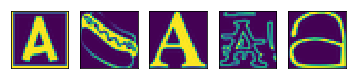

dataset_name  .\notMNIST_large\B.pickle dataset.shape[0]  52911 indices  [21896 21912 44156   417 14595]


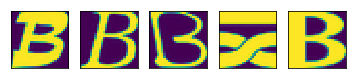

dataset_name  .\notMNIST_large\C.pickle dataset.shape[0]  52912 indices  [24313 19383  4118 52056 27111]


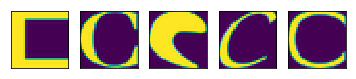

dataset_name  .\notMNIST_large\D.pickle dataset.shape[0]  52911 indices  [ 3286  1602 27651 32185 15434]


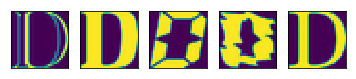

dataset_name  .\notMNIST_large\E.pickle dataset.shape[0]  52912 indices  [32734 24304 14356 37513  9700]


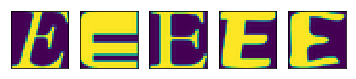

dataset_name  .\notMNIST_large\F.pickle dataset.shape[0]  52912 indices  [ 5372 22627 26129 32776 37679]


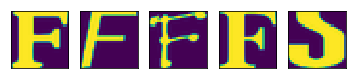

dataset_name  .\notMNIST_large\G.pickle dataset.shape[0]  52912 indices  [33686 46796  4037 19912 24184]


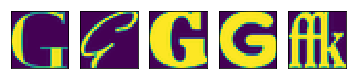

dataset_name  .\notMNIST_large\H.pickle dataset.shape[0]  52912 indices  [10448 10961 43033 18181 17919]


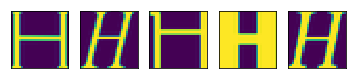

dataset_name  .\notMNIST_large\I.pickle dataset.shape[0]  52912 indices  [30435 10649 40620 35726 23296]


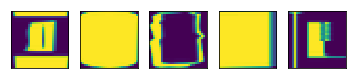

dataset_name  .\notMNIST_large\J.pickle dataset.shape[0]  52911 indices  [30671 39724  3305 35341 26828]


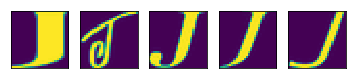

test_datasets  ['.\\notMNIST_small\\A.pickle', '.\\notMNIST_small\\B.pickle', '.\\notMNIST_small\\C.pickle', '.\\notMNIST_small\\D.pickle', '.\\notMNIST_small\\E.pickle', '.\\notMNIST_small\\F.pickle', '.\\notMNIST_small\\G.pickle', '.\\notMNIST_small\\H.pickle', '.\\notMNIST_small\\I.pickle', '.\\notMNIST_small\\J.pickle']
dataset_name  .\notMNIST_small\A.pickle dataset.shape[0]  1872 indices  [1588 1308  392  510   34]


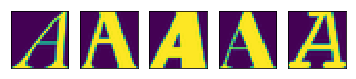

dataset_name  .\notMNIST_small\B.pickle dataset.shape[0]  1873 indices  [ 203 1192  279 1851  700]


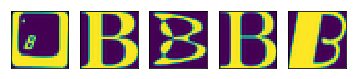

dataset_name  .\notMNIST_small\C.pickle dataset.shape[0]  1873 indices  [1835  322 1145 1544 1234]


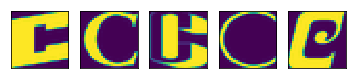

dataset_name  .\notMNIST_small\D.pickle dataset.shape[0]  1873 indices  [1403  186  389  753  245]


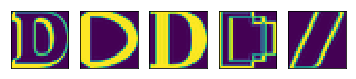

dataset_name  .\notMNIST_small\E.pickle dataset.shape[0]  1873 indices  [1322 1117  709 1687 1520]


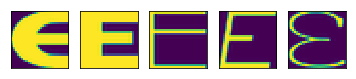

dataset_name  .\notMNIST_small\F.pickle dataset.shape[0]  1872 indices  [1276 1807 1541 1106 1219]


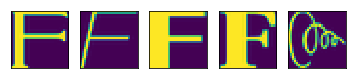

dataset_name  .\notMNIST_small\G.pickle dataset.shape[0]  1872 indices  [1848 1459  963 1510 1863]


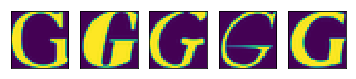

dataset_name  .\notMNIST_small\H.pickle dataset.shape[0]  1872 indices  [1060  363  960  359  945]


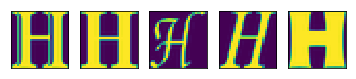

dataset_name  .\notMNIST_small\I.pickle dataset.shape[0]  1872 indices  [1311  905 1656  597 1026]


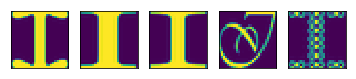

dataset_name  .\notMNIST_small\J.pickle dataset.shape[0]  1872 indices  [1738  878 1614 1031  757]


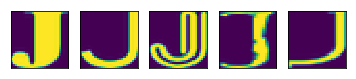

In [35]:
#Problem 2 : Let's verify that the data still looks good. 
#Displaying a sample of the labels and images from the ndarray. 
#Hint: you can use matplotlib.pyplot.

%matplotlib inline
def showProcessedRandom(dataset_name,n): # shows size of the sample
    with open(dataset_name, 'rb') as f:
        dataset = pickle.load(f)
        indices=np.random.choice(dataset.shape[0], n)
        print ('dataset_name ', dataset_name, 'dataset.shape[0] ',dataset.shape[0], 'indices ', indices)
        fig=plt.figure()
        for i in range(n):
            a=fig.add_subplot(1,n,i+1)
            plt.imshow(dataset[indices[i],:,:])
            # a.set_title(chr(labels[indices[i]]+ord('A')))
            a.axes.get_xaxis().set_visible(False)
            a.axes.get_yaxis().set_visible(False)
        plt.show()
    f.close()

print ('train_datasets ',train_datasets)
for name in train_datasets:
    showProcessedRandom(name,5) 

print ('test_datasets ',test_datasets)
for name in test_datasets:
    showProcessedRandom(name,5)

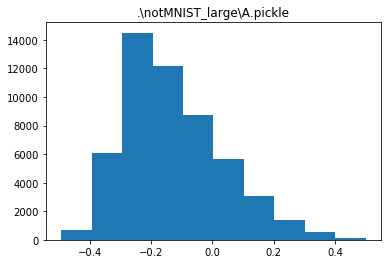

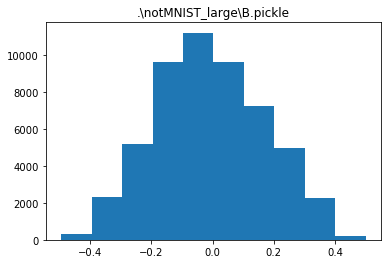

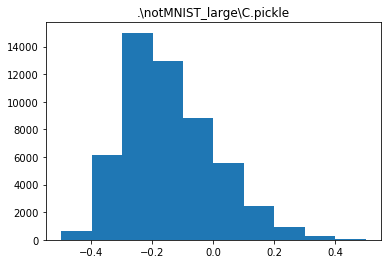

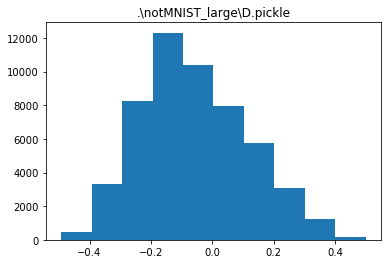

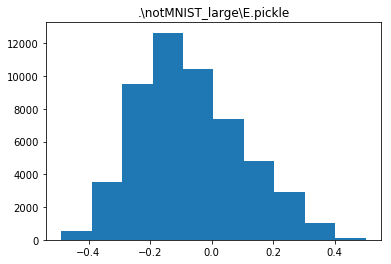

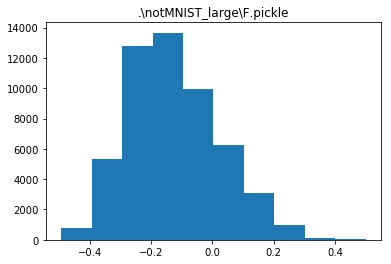

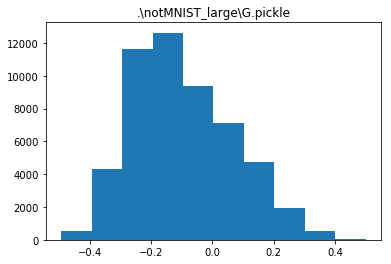

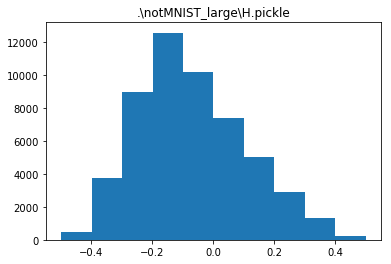

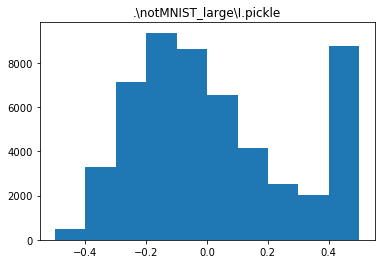

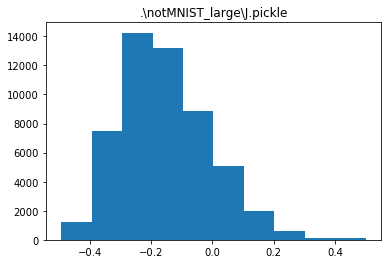

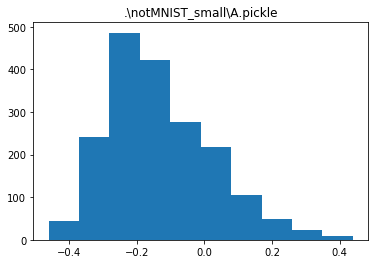

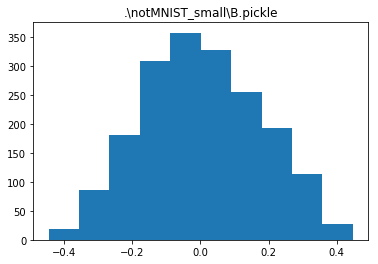

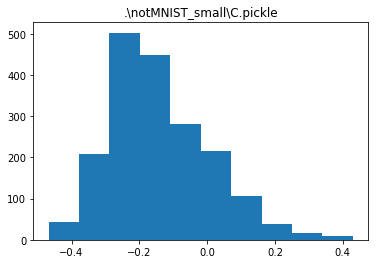

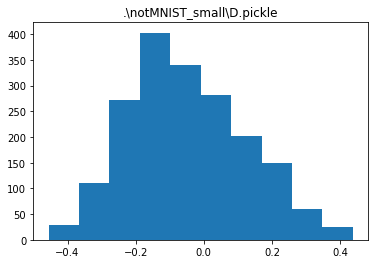

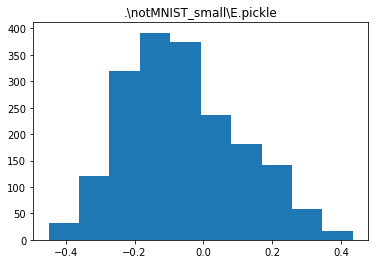

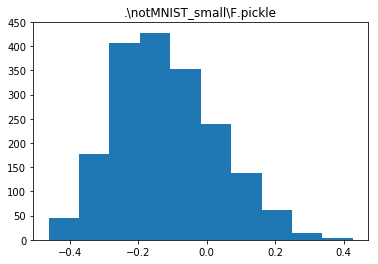

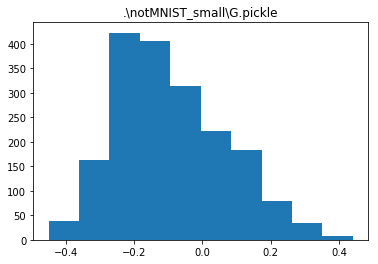

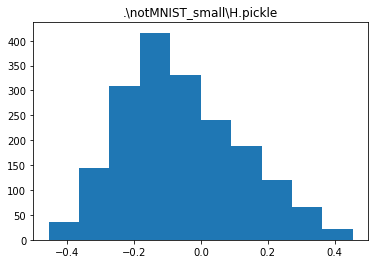

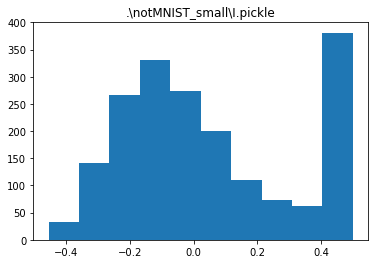

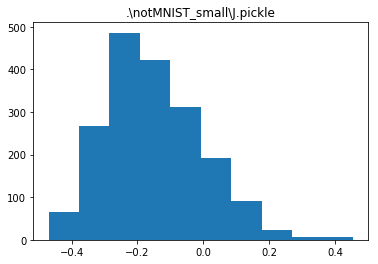

In [36]:
#Problem 3
#Another check: we expect the data to be balanced across classes. Verify that.

def showDistribution(dataset_name):
    data = []
    try:
        with open(dataset_name, 'rb') as f:
            data = pickle.load(f)
    except Exception as e:
        print('Unable to load data to', dataset_name, ':', e)

    fig, ax = plt.subplots()
    ax.set_title(dataset_name)
    ax.hist([np.mean(arr) for arr in data])
    plt.show()

for name in train_datasets:
    showDistribution(name)
for name in test_datasets:
    showDistribution(name)

In [37]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [38]:
#numpy.random.choice(a, size=None, replace=True, p=None) : Generates a random sample from a given 1-D array

#numpy.random.shuffle(x) : Modify a sequence in-place by shuffling its contents. => modify object itself
#This function only shuffles the array along the first axis of a multi-dimensional array. 
#The order of sub-arrays is changed but their contents remains the same.

#numpy.random.permutation(x) : Randomly permute a sequence, or return a permuted range => return a copy
#If x is a multi-dimensional array, it is only shuffled along its first index.

#random.randint(a, b)
#Return a random integer N such that a <= N <= b. Alias for randrange(a, b+1).


In [39]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

train set dataset.shape[0]  200000 indices  [112417  82244 197190 172777  68981   5333]


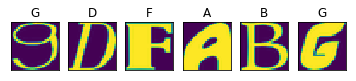

test set dataset.shape[0]  10000 indices  [6867 7823 4509 7714 4216 5621]


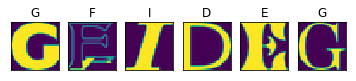

validation set dataset.shape[0]  10000 indices  [6984 9079 4348 7587 2986 4621]


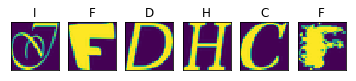

In [65]:
#Problem 4 : Convince yourself that the data is still good after shuffling!

fLabels = {0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E', 5 : 'F', 6 : 'G', 7 : 'H', 8 : 'I', 9 : 'J'}

def showProcessedShuffled(name,dataset,label,n): # shows size of the sample
    fig = plt.figure()
    indices=np.random.choice(dataset.shape[0], n)
    print (name, 'dataset.shape[0] ',dataset.shape[0], 'indices ', indices)
    for i in range(n):
            a=fig.add_subplot(1,n,i+1)
            plt.imshow(dataset[indices[i],:,:])
            tlabel = fLabels[label[indices[i]]]
            plt.title(tlabel)
            #a.set_title(chr(labels[indices[i]]+ord('A')))
            a.axes.get_xaxis().set_visible(False)
            a.axes.get_yaxis().set_visible(False)
    plt.show()

showProcessedShuffled('train set', train_dataset,train_labels,6)
showProcessedShuffled('test set', test_dataset,test_labels,6)
showProcessedShuffled('validation set', valid_dataset,valid_labels,6) 

In [66]:
#Finally, let's save the data for later reuse:

data_root = '.' 
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [67]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


In [69]:
#Problem 5
"""By construction, this dataset might contain a lot of overlapping samples, including training data 
that's also contained in the validation and test set! Overlap between training and test can skew the results 
if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect 
to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.
Optional questions:
What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
"""
#import time
import hashlib

#t1 = time.time()

train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

#np.in1d : Test whether each element of a 1-D array is also present in a second array.
#Returns a boolean array the same length as ar1 that is True where an element of ar1 is in ar2 and False otherwise.
valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

#magic boolean operations
#a = np.array([True, True, False, False])
#b = np.array([True, False, True, False])
#c = (a | b) :[ True  True  True False]
# ~c :        [False False False  True]
valid_keep = ~valid_in_train
test_keep  = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

#t2 = time.time()
#print("Time: %0.2fs" % (t2 - t1))
print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())



valid -> train overlap: 1099 samples
test  -> train overlap: 1314 samples
test  -> valid overlap: 228 samples


In [ ]:
#Problem 6
"""Let's get an idea of what an off-the-shelf classifier can give you on this data. 
It's always good to check that there is something to learn, and that it's a problem that is not so trivial 
that a canned solution solves it.
Train a simple model on this data using 50, 100, 1000 and 5000 training samples. 
Hint: you can use the LogisticRegression model from sklearn.linear_model.
Optional question: train an off-the-shelf model on all the data!
"""
